In [2]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [6]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # vanilla Backprop
#         dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [7]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3092, acc-0.1200, valid loss-2.3169, acc-0.0736, test loss-2.3132, acc-0.0864
Iter-20, train loss-2.3009, acc-0.1400, valid loss-2.3141, acc-0.0778, test loss-2.3104, acc-0.0912
Iter-30, train loss-2.3261, acc-0.0400, valid loss-2.3112, acc-0.0822, test loss-2.3074, acc-0.0957
Iter-40, train loss-2.3269, acc-0.0200, valid loss-2.3081, acc-0.0874, test loss-2.3044, acc-0.1009
Iter-50, train loss-2.3025, acc-0.0800, valid loss-2.3052, acc-0.0924, test loss-2.3014, acc-0.1068
Iter-60, train loss-2.2883, acc-0.1800, valid loss-2.3023, acc-0.0984, test loss-2.2985, acc-0.1143
Iter-70, train loss-2.3196, acc-0.0200, valid loss-2.2992, acc-0.1040, test loss-2.2955, acc-0.1210
Iter-80, train loss-2.2822, acc-0.1400, valid loss-2.2962, acc-0.1116, test loss-2.2925, acc-0.1262
Iter-90, train loss-2.3076, acc-0.1000, valid loss-2.2932, acc-0.1182, test loss-2.2895, acc-0.1311
Iter-100, train loss-2.2728, acc-0.2000, valid loss-2.2903, acc-0.1252, test loss-2.2866, acc-0.1393

Iter-830, train loss-2.0594, acc-0.6000, valid loss-2.0853, acc-0.4642, test loss-2.0814, acc-0.4791
Iter-840, train loss-2.0752, acc-0.5000, valid loss-2.0825, acc-0.4656, test loss-2.0786, acc-0.4808
Iter-850, train loss-2.1120, acc-0.4800, valid loss-2.0797, acc-0.4674, test loss-2.0759, acc-0.4820
Iter-860, train loss-2.0707, acc-0.4000, valid loss-2.0769, acc-0.4698, test loss-2.0729, acc-0.4834
Iter-870, train loss-2.1215, acc-0.3800, valid loss-2.0740, acc-0.4724, test loss-2.0701, acc-0.4851
Iter-880, train loss-2.0811, acc-0.5200, valid loss-2.0712, acc-0.4736, test loss-2.0673, acc-0.4869
Iter-890, train loss-2.0442, acc-0.5000, valid loss-2.0683, acc-0.4744, test loss-2.0643, acc-0.4877
Iter-900, train loss-2.0700, acc-0.4800, valid loss-2.0652, acc-0.4760, test loss-2.0613, acc-0.4895
Iter-910, train loss-2.0732, acc-0.5000, valid loss-2.0624, acc-0.4762, test loss-2.0584, acc-0.4898
Iter-920, train loss-2.0683, acc-0.4400, valid loss-2.0595, acc-0.4780, test loss-2.0555, a

Iter-1640, train loss-1.8165, acc-0.6400, valid loss-1.8511, acc-0.5394, test loss-1.8476, acc-0.5453
Iter-1650, train loss-1.8489, acc-0.5000, valid loss-1.8482, acc-0.5398, test loss-1.8447, acc-0.5461
Iter-1660, train loss-1.7967, acc-0.6600, valid loss-1.8453, acc-0.5400, test loss-1.8418, acc-0.5465
Iter-1670, train loss-1.8408, acc-0.4600, valid loss-1.8423, acc-0.5410, test loss-1.8389, acc-0.5476
Iter-1680, train loss-1.8434, acc-0.5400, valid loss-1.8395, acc-0.5410, test loss-1.8360, acc-0.5477
Iter-1690, train loss-1.8288, acc-0.6000, valid loss-1.8364, acc-0.5406, test loss-1.8330, acc-0.5476
Iter-1700, train loss-1.9330, acc-0.4200, valid loss-1.8336, acc-0.5414, test loss-1.8302, acc-0.5476
Iter-1710, train loss-1.8455, acc-0.4000, valid loss-1.8308, acc-0.5420, test loss-1.8274, acc-0.5476
Iter-1720, train loss-1.8178, acc-0.5200, valid loss-1.8279, acc-0.5420, test loss-1.8245, acc-0.5477
Iter-1730, train loss-1.8468, acc-0.5400, valid loss-1.8251, acc-0.5426, test loss

Iter-2450, train loss-1.6248, acc-0.5800, valid loss-1.6272, acc-0.5776, test loss-1.6251, acc-0.5798
Iter-2460, train loss-1.6633, acc-0.5200, valid loss-1.6245, acc-0.5784, test loss-1.6225, acc-0.5798
Iter-2470, train loss-1.6286, acc-0.6200, valid loss-1.6218, acc-0.5804, test loss-1.6199, acc-0.5811
Iter-2480, train loss-1.6731, acc-0.5400, valid loss-1.6193, acc-0.5810, test loss-1.6174, acc-0.5822
Iter-2490, train loss-1.6172, acc-0.5600, valid loss-1.6167, acc-0.5820, test loss-1.6147, acc-0.5830
Iter-2500, train loss-1.5846, acc-0.6200, valid loss-1.6140, acc-0.5814, test loss-1.6121, acc-0.5832
Iter-2510, train loss-1.5944, acc-0.5800, valid loss-1.6113, acc-0.5826, test loss-1.6095, acc-0.5835
Iter-2520, train loss-1.5935, acc-0.5200, valid loss-1.6088, acc-0.5834, test loss-1.6070, acc-0.5842
Iter-2530, train loss-1.5191, acc-0.7000, valid loss-1.6062, acc-0.5834, test loss-1.6044, acc-0.5839
Iter-2540, train loss-1.5113, acc-0.6600, valid loss-1.6035, acc-0.5834, test loss

Iter-3260, train loss-1.4303, acc-0.6400, valid loss-1.4337, acc-0.6296, test loss-1.4337, acc-0.6371
Iter-3270, train loss-1.4754, acc-0.6000, valid loss-1.4315, acc-0.6298, test loss-1.4316, acc-0.6381
Iter-3280, train loss-1.4689, acc-0.5800, valid loss-1.4294, acc-0.6304, test loss-1.4295, acc-0.6385
Iter-3290, train loss-1.4947, acc-0.6400, valid loss-1.4274, acc-0.6304, test loss-1.4274, acc-0.6393
Iter-3300, train loss-1.3881, acc-0.6400, valid loss-1.4252, acc-0.6320, test loss-1.4253, acc-0.6391
Iter-3310, train loss-1.5292, acc-0.5400, valid loss-1.4231, acc-0.6324, test loss-1.4232, acc-0.6395
Iter-3320, train loss-1.3863, acc-0.6800, valid loss-1.4209, acc-0.6334, test loss-1.4211, acc-0.6404
Iter-3330, train loss-1.5333, acc-0.5600, valid loss-1.4189, acc-0.6334, test loss-1.4190, acc-0.6411
Iter-3340, train loss-1.3411, acc-0.6600, valid loss-1.4167, acc-0.6346, test loss-1.4169, acc-0.6418
Iter-3350, train loss-1.4780, acc-0.5800, valid loss-1.4147, acc-0.6354, test loss

Iter-4070, train loss-1.2609, acc-0.6600, valid loss-1.2766, acc-0.6822, test loss-1.2785, acc-0.6897
Iter-4080, train loss-1.2548, acc-0.7400, valid loss-1.2748, acc-0.6834, test loss-1.2768, acc-0.6905
Iter-4090, train loss-1.2641, acc-0.6600, valid loss-1.2730, acc-0.6838, test loss-1.2750, acc-0.6907
Iter-4100, train loss-1.2650, acc-0.6800, valid loss-1.2713, acc-0.6838, test loss-1.2733, acc-0.6910
Iter-4110, train loss-1.3622, acc-0.5800, valid loss-1.2697, acc-0.6836, test loss-1.2716, acc-0.6912
Iter-4120, train loss-1.3256, acc-0.6200, valid loss-1.2681, acc-0.6840, test loss-1.2700, acc-0.6915
Iter-4130, train loss-1.1496, acc-0.7800, valid loss-1.2664, acc-0.6844, test loss-1.2683, acc-0.6916
Iter-4140, train loss-1.3261, acc-0.7000, valid loss-1.2647, acc-0.6848, test loss-1.2666, acc-0.6913
Iter-4150, train loss-1.2670, acc-0.7000, valid loss-1.2630, acc-0.6856, test loss-1.2649, acc-0.6917
Iter-4160, train loss-1.2510, acc-0.7000, valid loss-1.2612, acc-0.6862, test loss

Iter-4880, train loss-1.3526, acc-0.6400, valid loss-1.1505, acc-0.7176, test loss-1.1532, acc-0.7248
Iter-4890, train loss-1.0535, acc-0.7400, valid loss-1.1491, acc-0.7176, test loss-1.1518, acc-0.7251
Iter-4900, train loss-1.0638, acc-0.7800, valid loss-1.1476, acc-0.7186, test loss-1.1504, acc-0.7258
Iter-4910, train loss-1.1879, acc-0.7600, valid loss-1.1463, acc-0.7182, test loss-1.1490, acc-0.7260
Iter-4920, train loss-1.1323, acc-0.7200, valid loss-1.1449, acc-0.7190, test loss-1.1476, acc-0.7267
Iter-4930, train loss-1.1950, acc-0.6800, valid loss-1.1435, acc-0.7192, test loss-1.1462, acc-0.7270
Iter-4940, train loss-1.1032, acc-0.6600, valid loss-1.1421, acc-0.7192, test loss-1.1448, acc-0.7277
Iter-4950, train loss-1.2128, acc-0.7200, valid loss-1.1407, acc-0.7196, test loss-1.1435, acc-0.7280
Iter-4960, train loss-1.0199, acc-0.7600, valid loss-1.1393, acc-0.7206, test loss-1.1421, acc-0.7285
Iter-4970, train loss-1.1449, acc-0.7200, valid loss-1.1380, acc-0.7206, test loss

Iter-5690, train loss-1.1004, acc-0.7000, valid loss-1.0487, acc-0.7412, test loss-1.0525, acc-0.7486
Iter-5700, train loss-1.0044, acc-0.8400, valid loss-1.0476, acc-0.7412, test loss-1.0514, acc-0.7488
Iter-5710, train loss-1.1254, acc-0.7400, valid loss-1.0465, acc-0.7414, test loss-1.0503, acc-0.7488
Iter-5720, train loss-1.1770, acc-0.7600, valid loss-1.0454, acc-0.7418, test loss-1.0492, acc-0.7493
Iter-5730, train loss-1.0881, acc-0.7200, valid loss-1.0443, acc-0.7416, test loss-1.0481, acc-0.7495
Iter-5740, train loss-0.9649, acc-0.7800, valid loss-1.0432, acc-0.7416, test loss-1.0470, acc-0.7493
Iter-5750, train loss-0.9826, acc-0.7800, valid loss-1.0422, acc-0.7422, test loss-1.0460, acc-0.7494
Iter-5760, train loss-1.0518, acc-0.8000, valid loss-1.0412, acc-0.7422, test loss-1.0449, acc-0.7496
Iter-5770, train loss-1.0837, acc-0.7000, valid loss-1.0401, acc-0.7420, test loss-1.0438, acc-0.7502
Iter-5780, train loss-0.9625, acc-0.7600, valid loss-1.0390, acc-0.7422, test loss

Iter-6500, train loss-1.1024, acc-0.6400, valid loss-0.9661, acc-0.7558, test loss-0.9700, acc-0.7646
Iter-6510, train loss-0.9030, acc-0.8600, valid loss-0.9653, acc-0.7552, test loss-0.9691, acc-0.7647
Iter-6520, train loss-0.9940, acc-0.7800, valid loss-0.9644, acc-0.7552, test loss-0.9682, acc-0.7648
Iter-6530, train loss-1.2184, acc-0.6800, valid loss-0.9635, acc-0.7564, test loss-0.9673, acc-0.7654
Iter-6540, train loss-1.1395, acc-0.7400, valid loss-0.9626, acc-0.7564, test loss-0.9664, acc-0.7662
Iter-6550, train loss-0.8634, acc-0.8400, valid loss-0.9617, acc-0.7564, test loss-0.9655, acc-0.7664
Iter-6560, train loss-0.8834, acc-0.8000, valid loss-0.9608, acc-0.7570, test loss-0.9646, acc-0.7668
Iter-6570, train loss-1.0611, acc-0.7000, valid loss-0.9599, acc-0.7574, test loss-0.9637, acc-0.7670
Iter-6580, train loss-1.0063, acc-0.7200, valid loss-0.9590, acc-0.7576, test loss-0.9628, acc-0.7675
Iter-6590, train loss-0.9363, acc-0.7600, valid loss-0.9581, acc-0.7580, test loss

Iter-7310, train loss-0.9197, acc-0.7800, valid loss-0.8984, acc-0.7706, test loss-0.9021, acc-0.7804
Iter-7320, train loss-0.8854, acc-0.7600, valid loss-0.8976, acc-0.7708, test loss-0.9013, acc-0.7807
Iter-7330, train loss-0.9988, acc-0.8200, valid loss-0.8968, acc-0.7706, test loss-0.9005, acc-0.7808
Iter-7340, train loss-0.9621, acc-0.7400, valid loss-0.8961, acc-0.7710, test loss-0.8998, acc-0.7808
Iter-7350, train loss-0.8947, acc-0.7400, valid loss-0.8954, acc-0.7712, test loss-0.8991, acc-0.7808
Iter-7360, train loss-0.8439, acc-0.8000, valid loss-0.8945, acc-0.7714, test loss-0.8983, acc-0.7810
Iter-7370, train loss-0.8808, acc-0.7200, valid loss-0.8938, acc-0.7722, test loss-0.8975, acc-0.7813
Iter-7380, train loss-0.9282, acc-0.7800, valid loss-0.8930, acc-0.7720, test loss-0.8967, acc-0.7812
Iter-7390, train loss-0.9665, acc-0.7200, valid loss-0.8922, acc-0.7724, test loss-0.8960, acc-0.7817
Iter-7400, train loss-0.8983, acc-0.8000, valid loss-0.8914, acc-0.7726, test loss

Iter-8120, train loss-0.8266, acc-0.7800, valid loss-0.8402, acc-0.7876, test loss-0.8441, acc-0.7924
Iter-8130, train loss-0.7606, acc-0.8600, valid loss-0.8395, acc-0.7880, test loss-0.8434, acc-0.7924
Iter-8140, train loss-0.8562, acc-0.7600, valid loss-0.8389, acc-0.7886, test loss-0.8428, acc-0.7929
Iter-8150, train loss-0.8420, acc-0.8400, valid loss-0.8383, acc-0.7886, test loss-0.8422, acc-0.7928
Iter-8160, train loss-0.9050, acc-0.6400, valid loss-0.8376, acc-0.7894, test loss-0.8415, acc-0.7935
Iter-8170, train loss-0.7937, acc-0.8400, valid loss-0.8369, acc-0.7894, test loss-0.8409, acc-0.7937
Iter-8180, train loss-0.7798, acc-0.7800, valid loss-0.8363, acc-0.7896, test loss-0.8402, acc-0.7938
Iter-8190, train loss-0.9969, acc-0.7400, valid loss-0.8356, acc-0.7902, test loss-0.8395, acc-0.7942
Iter-8200, train loss-0.9093, acc-0.7800, valid loss-0.8349, acc-0.7904, test loss-0.8389, acc-0.7942
Iter-8210, train loss-0.9305, acc-0.7800, valid loss-0.8344, acc-0.7908, test loss

Iter-8930, train loss-0.7909, acc-0.7800, valid loss-0.7908, acc-0.7994, test loss-0.7943, acc-0.8057
Iter-8940, train loss-0.6907, acc-0.9000, valid loss-0.7902, acc-0.7998, test loss-0.7937, acc-0.8054
Iter-8950, train loss-0.8370, acc-0.8000, valid loss-0.7896, acc-0.7996, test loss-0.7932, acc-0.8057
Iter-8960, train loss-0.7007, acc-0.8600, valid loss-0.7891, acc-0.7996, test loss-0.7926, acc-0.8059
Iter-8970, train loss-0.7781, acc-0.8400, valid loss-0.7885, acc-0.7996, test loss-0.7921, acc-0.8060
Iter-8980, train loss-0.8662, acc-0.8200, valid loss-0.7880, acc-0.8002, test loss-0.7915, acc-0.8066
Iter-8990, train loss-0.7905, acc-0.7600, valid loss-0.7874, acc-0.8000, test loss-0.7909, acc-0.8062
Iter-9000, train loss-0.7781, acc-0.8200, valid loss-0.7868, acc-0.8004, test loss-0.7903, acc-0.8062
Iter-9010, train loss-0.8444, acc-0.7400, valid loss-0.7862, acc-0.8004, test loss-0.7898, acc-0.8067
Iter-9020, train loss-0.7388, acc-0.8200, valid loss-0.7856, acc-0.8006, test loss

Iter-9740, train loss-0.7930, acc-0.8000, valid loss-0.7472, acc-0.8132, test loss-0.7505, acc-0.8168
Iter-9750, train loss-0.8757, acc-0.6800, valid loss-0.7467, acc-0.8138, test loss-0.7500, acc-0.8167
Iter-9760, train loss-0.6576, acc-0.8200, valid loss-0.7461, acc-0.8138, test loss-0.7495, acc-0.8168
Iter-9770, train loss-0.9665, acc-0.7200, valid loss-0.7457, acc-0.8136, test loss-0.7490, acc-0.8171
Iter-9780, train loss-0.8037, acc-0.8000, valid loss-0.7452, acc-0.8136, test loss-0.7485, acc-0.8171
Iter-9790, train loss-0.7932, acc-0.8000, valid loss-0.7448, acc-0.8138, test loss-0.7481, acc-0.8170
Iter-9800, train loss-0.9688, acc-0.7600, valid loss-0.7443, acc-0.8138, test loss-0.7476, acc-0.8171
Iter-9810, train loss-0.8784, acc-0.7800, valid loss-0.7438, acc-0.8140, test loss-0.7471, acc-0.8174
Iter-9820, train loss-0.7472, acc-0.8600, valid loss-0.7433, acc-0.8144, test loss-0.7466, acc-0.8175
Iter-9830, train loss-0.7089, acc-0.8400, valid loss-0.7428, acc-0.8146, test loss

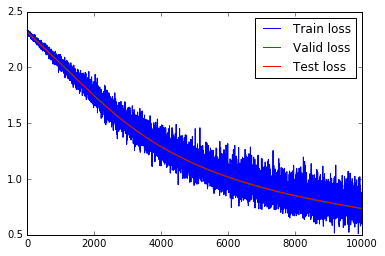

In [8]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

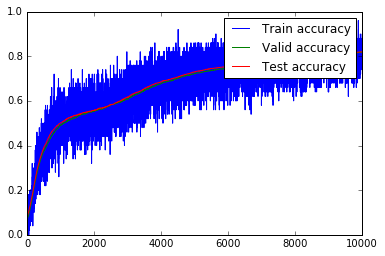

In [9]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()